In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

Obtencion del dataset

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.82MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 33.3MB/s]


Visualizacion de una imagen del dataset

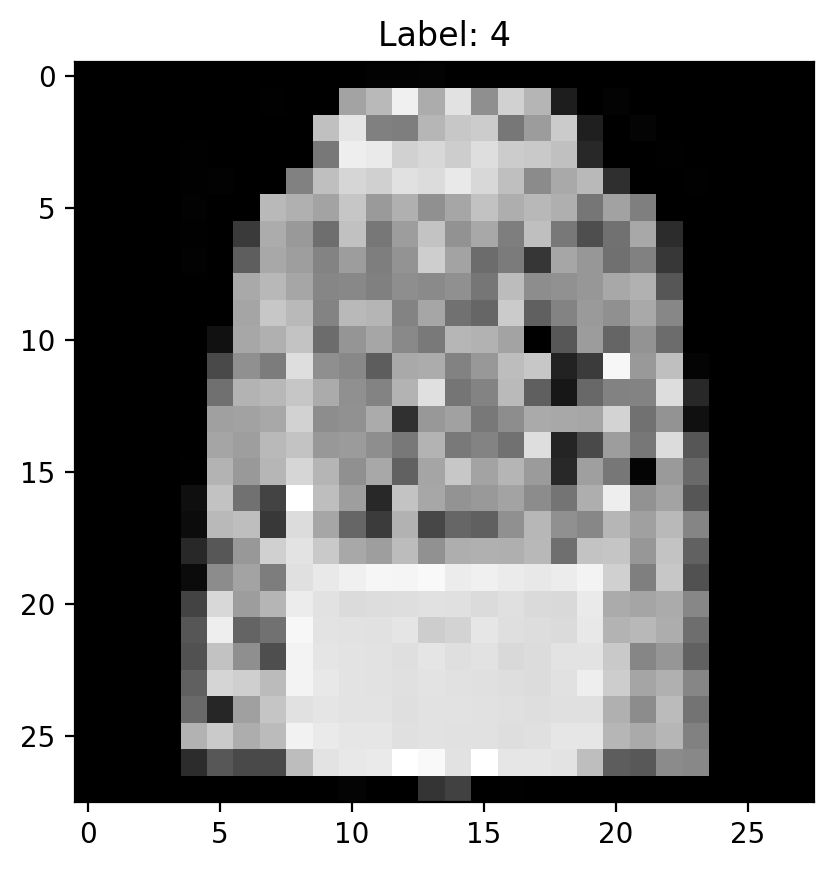

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Select the first image in the batch
image = images[0]

# Convert the image from PyTorch tensor to a NumPy array for matplotlib
# Also, remove the channel dimension if it's 1 (e.g., 1, 28, 28) -> (28, 28)
image = image.numpy().squeeze()

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()

Construyendo la red

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.

            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])

        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])

        self.output = nn.Linear(hidden_layers[-1], output_size)

        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''

        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)

        x = self.output(x)

        return F.log_softmax(x, dim=1)

Entrenamiento de la red

In [ ]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [516, 256], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Funcion de Validacion

In [ ]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

Entrenamiento

In [ ]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1

        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)

        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

            running_loss = 0

            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 1.310..  Test Loss: 0.785..  Test Accuracy: 0.713
Epoch: 1/2..  Training Loss: 0.815..  Test Loss: 0.644..  Test Accuracy: 0.755
Epoch: 1/2..  Training Loss: 0.736..  Test Loss: 0.626..  Test Accuracy: 0.768
Epoch: 1/2..  Training Loss: 0.659..  Test Loss: 0.602..  Test Accuracy: 0.777
Epoch: 1/2..  Training Loss: 0.670..  Test Loss: 0.549..  Test Accuracy: 0.795
Epoch: 1/2..  Training Loss: 0.639..  Test Loss: 0.542..  Test Accuracy: 0.799
Epoch: 1/2..  Training Loss: 0.614..  Test Loss: 0.553..  Test Accuracy: 0.792
Epoch: 1/2..  Training Loss: 0.574..  Test Loss: 0.514..  Test Accuracy: 0.811
Epoch: 1/2..  Training Loss: 0.561..  Test Loss: 0.513..  Test Accuracy: 0.810
Epoch: 1/2..  Training Loss: 0.571..  Test Loss: 0.518..  Test Accuracy: 0.811
Epoch: 1/2..  Training Loss: 0.559..  Test Loss: 0.509..  Test Accuracy: 0.810
Epoch: 1/2..  Training Loss: 0.580..  Test Loss: 0.546..  Test Accuracy: 0.797
Epoch: 1/2..  Training Loss: 0.555..  Test Loss: 0.4

Inferencia

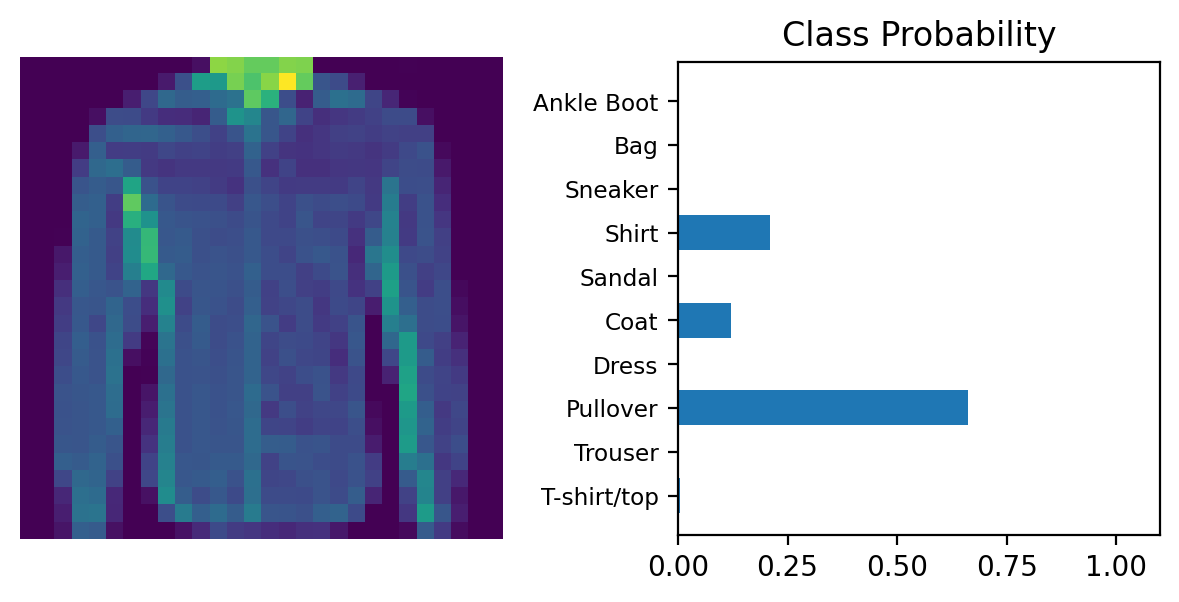

In [ ]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()